In [ ]:
%cd /content

# download the predictive coding repository
!git clone https://github.com/jgornet/predictive-coding-recovers-maps.git
%cd predictive-coding-recovers-maps/notebooks
!pip install -r ../requirements.txt

In [2]:
from predictive_coding.analysis import *
from predictive_coding.models.encoder_decoder import PredictiveCoder, Autoencoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/home/jamesgornet/miniconda3/envs/malmo/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/jamesgornet/Documents/navigation/predictive-coding-recovers-maps/notebooks/predictive_coding/trainer.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Autoencoding

In this Google Colab notebook, we apply a pre-trained autoencoding neural network to a dataset containing observations from an agent navigating the Minecraft environment. First, we load the autoencoding neural network. Next, we import the validation dataset that captures episodes of an agent moving through various terrains in Minecraft. Our goal is to utilize the network's decoder to generate latent vectors from the data. These vectors provide a condensed representation of the agent's visual information within the environment.


In [ ]:
import torch

model = Autoencoder(
    in_channels=3,
    out_channels=3,
    layers=[2, 2, 2, 2],
)
model.load_state_dict(torch.load('../weights/autoencoder.ckpt'))
model = model.to('cuda:0')

In [4]:
images = torch.from_numpy(np.load('../weights/autoencoder-environment-images.npy')).to('cuda:0')
latents = generate_latents(model, images).reshape(-1, 128, 8, 8)
positions = np.load('../weights/autoencoder-environment-positions.npy')[:, :2]

In [ ]:
position_decoder = PositionDecoder()
position_decoder.train(latents)

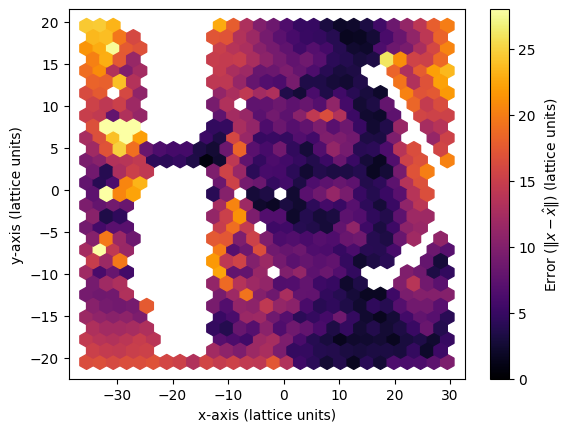

In [6]:
error_map(position_decoder, latents)
plt.show()

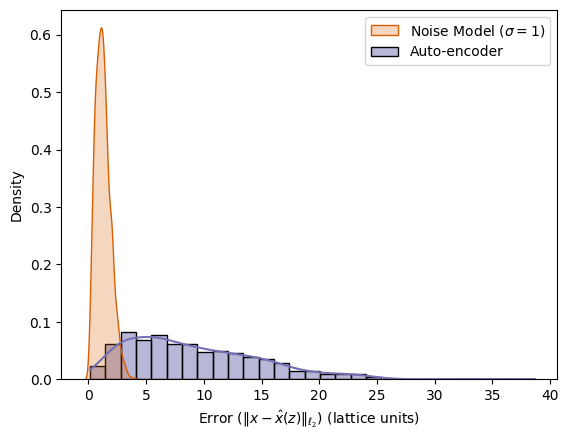

In [7]:
error = position_decoder.error(latents)
noise = np.linalg.norm(np.random.randn(len(error), 2), axis=1)
error_histogram([error], ["Auto-encoder"], [plt.cm.Dark2(2)])
sns.kdeplot(noise, fill=True, label="Noise Model ($\sigma=1$)", color=plt.cm.Dark2(1))
plt.legend()
plt.show()

In [6]:
images = torch.from_numpy(np.load('../weights/predictive-coder-path-images.npy')).to('cuda:0')
latents = generate_latents(model, images).reshape(-1, 128, 8, 8)
positions = np.load('../weights/autoencoder-path-positions.npy')[:, :2]

In [7]:
latents = Latents(latents, positions)

In [8]:
regression = LogRegression(1, 1, latents, "Auto-encoder", plt.cm.Dark2(2))
regression.train(latents)

/home/jamesgornet/Documents/navigation/predictive-coding-recovers-maps/notebooks/predictive_coding/analysis.py:374: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


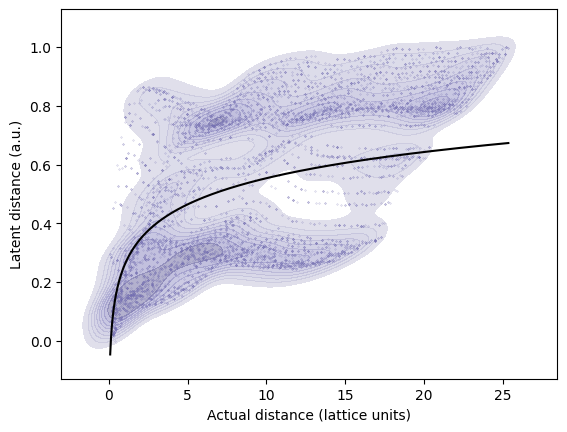

In [9]:
distribution_plot([regression])
plt.show()

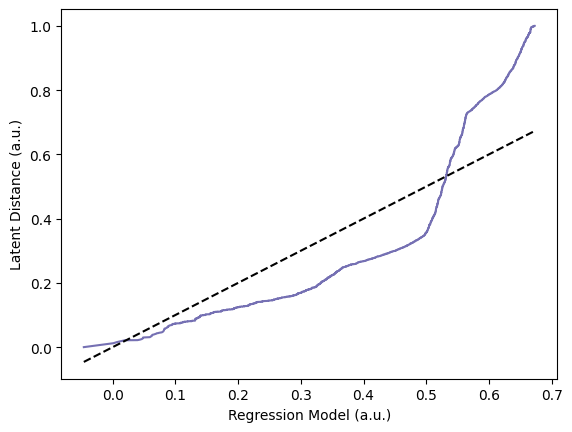

In [10]:
qq_plot([regression])
plt.show()

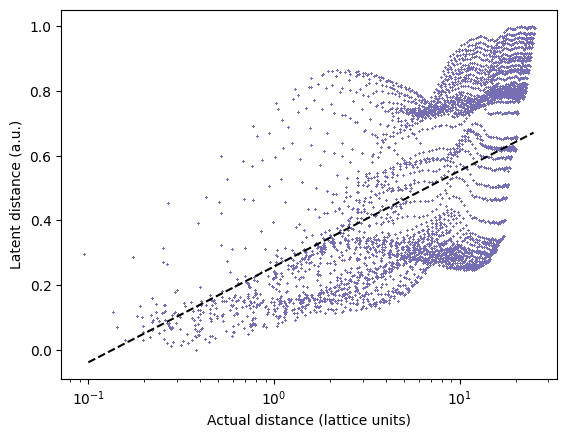

In [11]:
regression_plot([regression])
plt.show()